# Preprocessing and Modeling CTR Prediction

In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reading Dataset and New Time Features

In [2]:
# Reading file (train_shuffled_with_columns.csv is result of shuffling the original train.csv file)
dataset = r'train_shuffled.csv' 
df = pd.read_csv(dataset,nrows=1000000)

# Rename column 'hour' to 'timestamp'
df.rename(columns={'hour':'timestamp'}, inplace=True)

# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%y%m%d%H')

# Sorting rows per 'hour'
df = df.sort_values(by='timestamp')
df.head(2)

,id,click,timestamp,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
325876,15348754204581273148,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15705,320,50,1722,0,35,-1,79
876704,8920252239684887372,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32


In [3]:
# Time sin and cos

# Extract the hour of the day from the timestamp
df['hour'] = df['timestamp'].dt.hour

# Convert hours to radians (since there are 24 hours in a day)
df['radians'] = (df['hour'] / 24) * 2 * np.pi

# Apply sine and cosine transformations
df['sin_time'] = np.sin(df['radians'])
df['cos_time'] = np.cos(df['radians'])

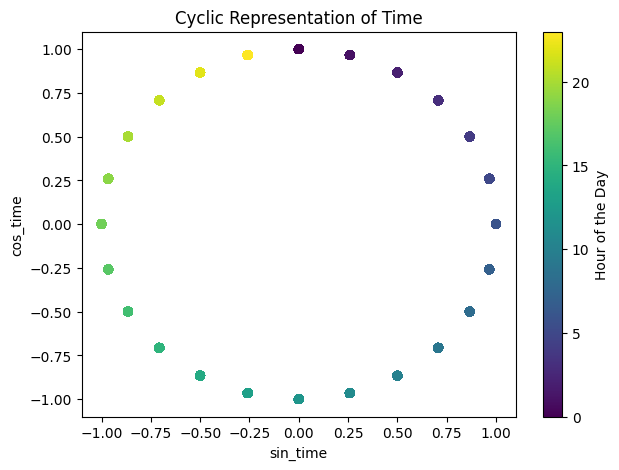

In [4]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
scatter_plot = ax.scatter(df['sin_time'], df['cos_time'], c=df['hour'], cmap='viridis')
ax.set_xlabel('sin_time')
ax.set_ylabel('cos_time')
ax.set_title('Cyclic Representation of Time')
fig.colorbar(scatter_plot, label='Hour of the Day')

plt.show()

In [5]:
# Creating new features

df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d') # yyyy-mm-dd

# num_impressions_user_day: Number of impressions a user (device_id) has in a day
df['num_impressions_user_day'] = df.groupby(['date', 'device_id'])['id'].transform('count')

# time_interval_last_visit: Time interval from the last visit
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['device_id', 'timestamp'], inplace=True)
df['time_interval_last_visit'] = df.groupby('device_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# num_days_user_appears: Number of days the user appeared
df['num_days_user_appears'] = df.groupby('device_id')['date'].transform('nunique')

# num_previous_clicks: number of clicks the user has done 
df['num_previous_clicks'] = df.groupby('device_id')['click'].cumsum() - df['click']

print('new features created')

new features created


In [6]:
# Dropping columns 
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
    print('column id was deleted')

if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)
    print('column timestamp was deleted')

if 'radians' in df.columns:
    df.drop(columns=['radians'], inplace=True)
    print('column radians was deleted')

if 'hour' in df.columns:
    df.drop(columns=['hour'], inplace=True)
    print('column hour was deleted')

if 'date' in df.columns:
    df.drop(columns=['date'], inplace=True)
    print('column date was deleted')

column id was deleted
column timestamp was deleted
column radians was deleted
column hour was deleted
column date was deleted


# Adressing imbalance problem: Downsampling majority class = 0

In [7]:
# Separate majority and minority classes
df_majority = df[df['click'] == 0]
df_minority = df[df['click'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the DataFrame
df = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class counts
print(df['click'].value_counts())

click
1    169554
0    169554
Name: count, dtype: int64


In [8]:
df.shape

(339108, 28)

In [9]:
# Summary of Number of unique values and data type per column
summary = pd.DataFrame(df.nunique(), columns=['num_unique'])
summary['dtype'] = df.dtypes
summary

,num_unique,dtype
click,2,int64
C1,7,int64
banner_pos,7,int64
site_id,2065,object
site_domain,2060,object
site_category,20,object
app_id,2089,object
app_domain,146,object
app_category,22,object
device_id,52611,object


In [10]:
variable_types = {
    'click': 'target',
    'C1': 'categorical nominal to encode',
    'banner_pos': 'categorical ready to use',
    'site_id': 'categorical nominal to encode',
    'site_domain': 'categorical nominal to encode',
    'site_category': 'categorical nominal to encode',
    'app_id': 'categorical nominal to encode',
    'app_domain': 'categorical nominal to encode',
    'app_category': 'categorical nominal to encode',
    'device_id': 'categorical nominal to encode',
    'device_ip': 'categorical nominal to encode',
    'device_model': 'categorical nominal to encode',
    'device_type': 'categorical ready to use',
    'device_conn_type': 'categorical ready to use',
    'C14': 'categorical nominal to encode',
    'C15': 'categorical ready to use',
    'C16': 'categorical ready to use',
    'C17': 'categorical ready to use',
    'C18': 'categorical ready to use',
    'C19': 'categorical ready to use',
    'C20': 'categorical nominal to encode', # Most popular label is '-1' and the others have a format like this '100098'
    'C21': 'categorical ready to use',
    'num_impressions_user_day': 'numerical',
    'time_interval_last_visit': 'numerical',
    'num_days_user_appears': 'numerical',
    'num_previous_clicks': 'numerical',
    'sin_time': 'numerical',
    'cos_time': 'numerical'
}

In [11]:
def check_repeated_counts(counts_dict):
    """
    Function to check for repeated count values in a counts dictionary.
    
    Args:
    counts_dict (dict): A dictionary where the keys are the categories and the values are the counts.
    
    Returns:
    bool: True if there are repeated counts, False otherwise.
    """
    unique_counts = set(counts_dict.values())
    return len(unique_counts) != len(counts_dict)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher

def power_of_2(x):
    if x > 6000:
        return (2 ** (int(np.log2(x)) - 13))
    elif x > 500:
        return (2 ** (int(np.log2(x)) - 5))
    elif x > 100:
        return (2 ** (int(np.log2(x)) - 2))
    else:
        return (2 ** (int(np.log2(x))))


def encode_categorical_column(column, column_type, n_features=None):
    """
    Encode a single categorical column based on its type.

    Args:
    column (Series): The Series containing the categorical data.
    column_type (str): The type of the column.
    n_features (int, optional): The number of features for feature hashing.

    Returns:
    Series: The encoded categorical column.
    """
    encoded_column = column.copy()
    
    if column_type == 'categorical ordinal to encode':
        # Apply label encoding
        label_encoder = LabelEncoder()
        encoded_column = label_encoder.fit_transform(encoded_column)
        print(f"Column {column.name} has been encoded with method: Label encoding")
    elif column_type == 'categorical nominal to encode':
        # Check for repeated counts
        counts_dict = column.value_counts().to_dict()
        repeated_counts = check_repeated_counts(counts_dict)
        if not repeated_counts:
            # Apply count frequency encoding
            encoded_column = column.map(column.value_counts())
            print(f"Column {column.name} has been encoded with method: Count Encoding")
        else:
            # Apply feature hashing
            if n_features is None:
                # Calculate the nearest power of 2 less than the number of unique values
                n_features = power_of_2(len(column.unique()))
                n_features = int(n_features)  # Convert to integer
                print(f"Column {column.name} will be encoded with method: Feature Hashing with n_features={n_features}")
            # Convert each element in the column to a string and wrap it in a list
            column_strings = column.astype(str).apply(lambda x: [x])
            hasher = FeatureHasher(n_features=n_features, input_type='string')
            hashed_features = hasher.fit_transform(column_strings)
            encoded_column = pd.Series(hashed_features.toarray().tolist())
            print(f"Column {column.name} has been encoded with method: Feature Hashing")
    else:
        raise ValueError("Invalid column type. Must be 'categorical ordinal to encode' or 'categorical nominal to encode'.")
    
    return encoded_column

In [13]:
# Create a new DataFrame to store the encoded columns
df_encoded = pd.DataFrame()

# Iterate over each column in the original DataFrame
for column_name, column_type in variable_types.items():
    # Check if the column needs encoding
    if column_type in ['categorical ordinal to encode', 'categorical nominal to encode']:
        # Encode the column
        encoded_column = encode_categorical_column(df[column_name], column_type)
        # Add the encoded column to the new DataFrame
        df_encoded[column_name] = encoded_column
    else:
        # For non-categorical columns, simply copy them to the new DataFrame
        df_encoded[column_name] = df[column_name]

# Display the encoded DataFrame
print('df was encoded successfully')

Column C1 has been encoded with method: Count Encoding
Column site_id will be encoded with method: Feature Hashing with n_features=64
Column site_id has been encoded with method: Feature Hashing
Column site_domain will be encoded with method: Feature Hashing with n_features=64
Column site_domain has been encoded with method: Feature Hashing
Column site_category has been encoded with method: Count Encoding
Column app_id will be encoded with method: Feature Hashing with n_features=64
Column app_id has been encoded with method: Feature Hashing
Column app_domain will be encoded with method: Feature Hashing with n_features=32
Column app_domain has been encoded with method: Feature Hashing
Column app_category will be encoded with method: Feature Hashing with n_features=16
Column app_category has been encoded with method: Feature Hashing
Column device_id will be encoded with method: Feature Hashing with n_features=4
Column device_id has been encoded with method: Feature Hashing
Column device_

In [14]:
df_encoded.shape

(339108, 28)

### Splitting Features and Target

In [15]:
# Columns encoded with feature hashing and their respective n_features
columns_to_hash = {
    'site_id': 64,
    'site_domain': 64,
    'app_id': 64,
    'app_domain': 32,
    'app_category': 16,
    'device_id': 4,
    'device_ip': 16,
    'device_model': 128,
    'C14': 32,
    'C20': 32
}

# Function to apply feature hashing and one-hot encoding
def flatten_categorical(df, column, n_features):
    # Apply feature hashing
    hashed_features = df[column].apply(lambda x: hash(str(x)) % n_features)
    
    # Convert hashed features into binary columns using one-hot encoding
    one_hot_encoded = pd.get_dummies(hashed_features, prefix=column)
    
    return one_hot_encoded

# Flatten categorical variables using feature hashing and one-hot encoding
flattened_categorical = []
for column, n_features in columns_to_hash.items():
    flattened_categorical.append(flatten_categorical(df_encoded, column, n_features))

# Concatenate flattened categorical variables with the original dataframe
df_encoded_flattened = pd.concat([df_encoded] + flattened_categorical, axis=1)

# Remove original categorical columns
df_encoded_flattened.drop(columns=columns_to_hash.keys(), inplace=True)

# Display the resulting dataframe
print(df_encoded_flattened.head())


   click      C1  banner_pos  site_category  device_type  device_conn_type  \
0      1  311011           0          67258            1                 0   
1      0  311011           1         108536            1                 2   
2      0  311011           1         108536            1                 0   
3      0   20535           0         125688            0                 0   
4      1  311011           0         125688            1                 2   

   C15  C16   C17  C18  ...  C20_22  C20_23  C20_24  C20_25  C20_26  C20_27  \
0  320   50  2512    2  ...   False   False   False   False   False   False   
1  320   50  1991    2  ...   False   False   False   False   False   False   
2  320   50  2526    3  ...    True   False   False   False   False   False   
3  320   50   549    3  ...   False   False   False   False   False   False   
4  320   50  1248    2  ...   False   False   False   False   False   False   

   C20_28  C20_29  C20_30  C20_31  
0   False   False   

In [16]:
# Separate features and target
X = df_encoded_flattened.drop('click', axis=1)  # Features
y = df_encoded_flattened['click']  # Target

## Splitting data in training and test (without SVD)

In [17]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2, random_state=42)

# Clustering K-Means

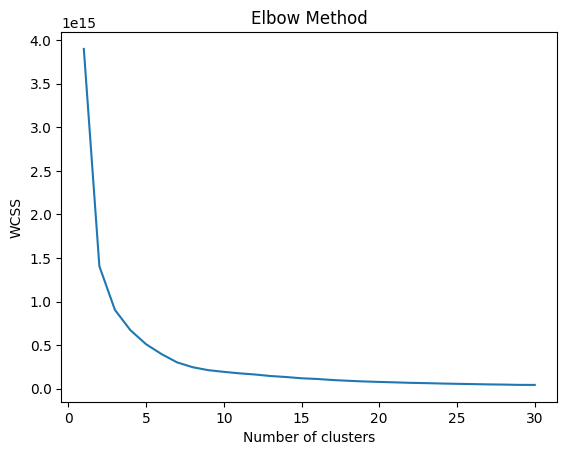

In [33]:
#Elbow method to choose number of clusters (k =4 was chosen)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define the range of clusters you want to try
max_clusters = 30  

# Initialize a list to store the within-cluster sum of squares (WCSS) for different number of clusters
wcss = []

# Calculate WCSS for different values of k
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_encoded_flattened)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [25]:
# Clustering
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

# Cluster assignments for training data
train_cluster_assignments = kmeans.predict(X_train)
print(train_cluster_assignments)

# Add cluster assignments to the training data
X_train_clustered = X_train.copy()
X_train_clustered['cluster'] = train_cluster_assignments

X_train_clustered.head()

c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 3 3 ... 3 3 1]


,C1,banner_pos,site_category,device_type,device_conn_type,C15,C16,C17,C18,C19,...,C20_23,C20_24,C20_25,C20_26,C20_27,C20_28,C20_29,C20_30,C20_31,cluster
330553,311011,1,108536,1,0,320,50,2528,0,35,...,False,False,False,False,False,False,False,False,False,0
313573,311011,0,125688,1,2,320,50,2229,0,687,...,False,False,False,False,False,False,False,False,False,3
55944,311011,0,125688,1,0,320,50,2480,3,297,...,False,False,False,False,False,False,False,False,False,3
307251,311011,1,108536,1,0,320,50,2528,0,35,...,False,False,False,False,False,False,False,False,False,0
299467,311011,1,108536,1,0,320,50,2333,0,39,...,False,False,False,False,False,False,False,False,False,0


c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


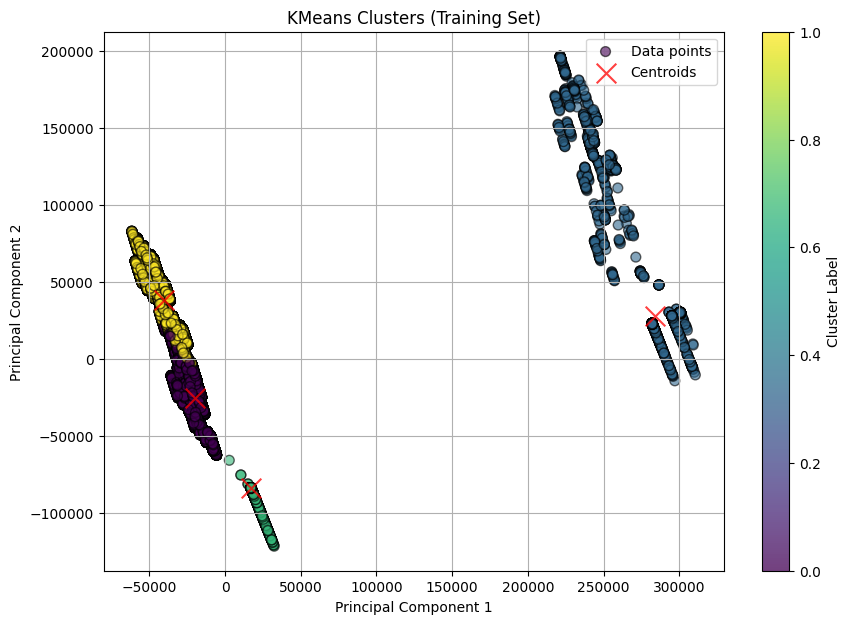

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plotting function
def plot_clusters(X, cluster_labels, title, centers=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6, label='Data points')
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x', label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster Label')
    plt.legend()
    plt.grid(True)
    plt.show()

# Getting centroids for visualization
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot training clusters
plot_clusters(X_train_pca, train_cluster_assignments, 'KMeans Clusters (Training Set)', centroids_pca)

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

models = {}

for i in range(n_clusters):
    # Prepare data for this cluster
    cluster_data = X_train_clustered[X_train_clustered['cluster'] == i].drop(['cluster'], axis=1)
    cluster_target = y_train[X_train_clustered['cluster'] == i]
    
    # Ensure all data is numeric and the correct type
    cluster_data = cluster_data.astype('float32')
    cluster_target = cluster_target.astype('float32')
    
    # Scale the data
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    # Logistic Regression
    lr = LogisticRegression(C=100, penalty='l2', solver='liblinear', random_state=42)
    lr.fit(cluster_data_scaled, cluster_target)
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=4, min_samples_split=10, random_state=42)
    rf.fit(cluster_data_scaled, cluster_target)
    
    # XGBoost
    xgb = XGBClassifier(objective='binary:logistic', colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    xgb.fit(cluster_data_scaled, cluster_target)
    
    # CatBoost
    cat_features = [index for index, dtype in enumerate(cluster_data.dtypes) if dtype == 'object']
    cat = CatBoostClassifier(depth=8, iterations=300, learning_rate=0.1, cat_features=cat_features, random_state=42, verbose=False)
    cat.fit(cluster_data_scaled, cluster_target)
    
    # Feedforward Neural Network
    fnn = Sequential([
        Dense(64, activation='relu', input_shape=(cluster_data_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    fnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    fnn.fit(cluster_data_scaled, cluster_target, epochs=10, batch_size=32, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
    
    # Store models
    models[i] = {
        'Logistic Regression': lr,
        'Random Forest': rf,
        'XGBoost': xgb,
        'CatBoost': cat,
        'Neural Network': fnn
    }

print('Models were trained successfully for each cluster')


Models were trained successfully for each cluster


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, log_loss, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cluster import KMeans

# Assuming the necessary data is loaded into X_train_clustered, y_train, X_test, y_test

models = {}
cv_scores = {}
scaler = StandardScaler()

for cluster_id in range(n_clusters):
    cluster_data = X_train_clustered[X_train_clustered['cluster'] == cluster_id].drop(['cluster'], axis=1)
    cluster_target = y_train[X_train_clustered['cluster'] == cluster_id]
    
    cluster_data_scaled = scaler.fit_transform(cluster_data.astype('float32'))
    cluster_target = cluster_target.astype('float32')
    
    # Logistic Regression
    lr = LogisticRegression(C=100, penalty='l2', solver='liblinear', random_state=42)
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=4, min_samples_split=10, random_state=42)
    
    # XGBoost
    xgb = XGBClassifier(objective='binary:logistic', colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
    # CatBoost
    cat_features = [index for index, dtype in enumerate(cluster_data.dtypes) if dtype == 'object']
    cat = CatBoostClassifier(depth=8, iterations=300, learning_rate=0.1, cat_features=cat_features, random_state=42, verbose=False)
    
    # Store models
    models[cluster_id] = {
        'Logistic Regression': lr,
        'Random Forest': rf,
        'XGBoost': xgb,
        'CatBoost': cat
    }
    
    # Train and perform cross-validation
    cv_scores[cluster_id] = {}
    for model_name, model in models[cluster_id].items():
        model.fit(cluster_data_scaled, cluster_target)
        score = cross_val_score(model, cluster_data_scaled, cluster_target, cv=5, scoring='f1')
        cv_scores[cluster_id][model_name] = score.mean()
        print(f"Cluster {cluster_id}, Model {model_name}, CV F1-Score: {score.mean():.4f}")

best_models = {}

for cluster_id in cv_scores:
    best_model = max(cv_scores[cluster_id], key=cv_scores[cluster_id].get)
    best_models[cluster_id] = models[cluster_id][best_model]
    print(f"Best model for Cluster {cluster_id} is {best_model} with F1-Score: {cv_scores[cluster_id][best_model]:.4f}")

# Predict clusters for the test set using a KMeans model
# Ensure KMeans has been trained or fit it as shown
kmeans = KMeans(n_clusters=n_clusters).fit(X_train_clustered.drop(['cluster'], axis=1))
test_cluster_assignments = kmeans.predict(X_test)

# Prepare lists to collect probabilities, predicted and actual labels
y_prob = []
y_pred = []
y_true = []

for i in range(len(X_test)):
    cluster_id = test_cluster_assignments[i]
    best_model = best_models[cluster_id]
    
    # Ensure the same transformation on test data
    test_data_point = X_test.iloc[i:i+1]  # Use slicing to keep DataFrame format
    test_data_point_scaled = scaler.transform(test_data_point)
    
    # Predict probabilities for log loss calculation
    if hasattr(best_model, "predict_proba"):
        prob = best_model.predict_proba(test_data_point_scaled)[0]
        y_prob.append(prob[1])  # Assuming binary classification, adjust if multiclass
    else:
        # For models like SVM that do not support predict_proba by default
        prob = best_model.decision_function(test_data_point_scaled)
        prob = (np.exp(prob) / (1 + np.exp(prob)))  # Sigmoid function to convert to probability
        y_prob.append(prob)
    
    # Predict labels for other metrics
    label = best_model.predict(test_data_point_scaled)
    y_pred.append(label[0])
    y_true.append(y_test.iloc[i])

# Convert lists to arrays for easier handling in metrics calculation
y_prob = np.array(y_prob)
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate log loss
log_loss_value = log_loss(y_true, y_prob)
print("Log Loss - KMeans:", log_loss_value)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate TPR (True Positive Rate or Sensitivity)
tpr = tp / (tp + fn)
print("True Positive Rate (TPR) - KMeans:", tpr)

# Calculate FPR (False Positive Rate)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR) - KMeans:", fpr)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)
print("F1 Score - KMeans:", f1)


Cluster 0, Model Logistic Regression, CV F1-Score: 0.6956
Cluster 0, Model Random Forest, CV F1-Score: 0.7048
Cluster 0, Model XGBoost, CV F1-Score: 0.7037
Cluster 0, Model CatBoost, CV F1-Score: 0.7023
Cluster 1, Model Logistic Regression, CV F1-Score: 0.6600
Cluster 1, Model Random Forest, CV F1-Score: 0.6988
Cluster 1, Model XGBoost, CV F1-Score: 0.6868
Cluster 1, Model CatBoost, CV F1-Score: 0.6888
Cluster 2, Model Logistic Regression, CV F1-Score: 0.5531
Cluster 2, Model Random Forest, CV F1-Score: 0.5690
Cluster 2, Model XGBoost, CV F1-Score: 0.5882
Cluster 2, Model CatBoost, CV F1-Score: 0.5907
Cluster 3, Model Logistic Regression, CV F1-Score: 0.6939
Cluster 3, Model Random Forest, CV F1-Score: 0.7018
Cluster 3, Model XGBoost, CV F1-Score: 0.6997
Cluster 3, Model CatBoost, CV F1-Score: 0.7007
Best model for Cluster 0 is Random Forest with F1-Score: 0.7048
Best model for Cluster 1 is Random Forest with F1-Score: 0.6988
Best model for Cluster 2 is CatBoost with F1-Score: 0.5907
B

c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Log Loss - KMeans: 0.6389668308808905
True Positive Rate (TPR) - KMeans: 0.6170859013299519
False Positive Rate (FPR) - KMeans: 0.3336380525493203
F1 Score - KMeans: 0.6326737313116959


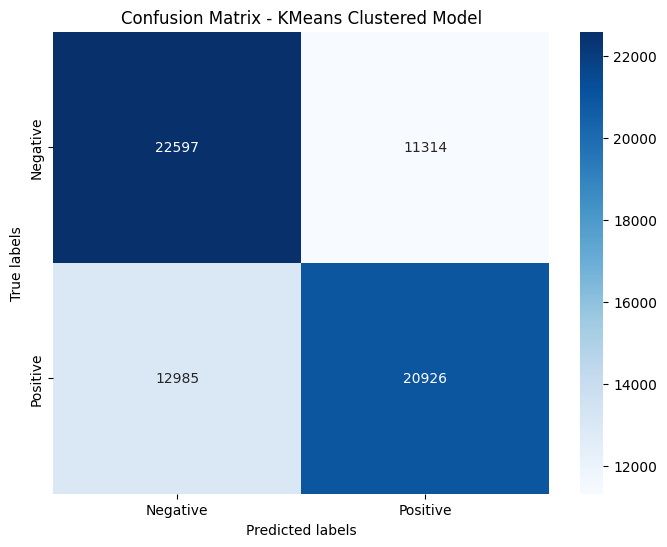

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Construct the confusion matrix array from the TN, FP, FN, TP values
confusion_mat = np.array([[tn, fp], [fn, tp]])

# Set up the plot with matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Add labels and title for clarity
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - KMeans Clustered Model')

# Display the plot
plt.show()